In [33]:
import geopandas as gpd
import pandas as pd
import ace_tools
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

ModuleNotFoundError: No module named 'ace_tools'

In [13]:
ROC_m1 = r'/Volumes/PhD/imagery/masters/ROC/M1_CT_ROC.shp'
ROC_m1 = gpd.read_file(ROC_m1)
ROC_m1.columns


Index(['BASIN_ID', 'Shape_Leng', 'Shape_Area', 'Segment_ID', 'Acc_Cl',
       'Perim_Buff', 'InsidePeri', 'OutsidePer', 'Fire_ID', 'Fire_Segme',
       'L_X1', 'L_X2', 'L_X3', 'V_X1', 'V_X2', 'Shape_Le_1', 'R', 'V_X3', 'X',
       'ExpX', 'P', 'PCl', 'PCl_Legend', 'LnV', 'Volume', 'VolMin', 'VolMax',
       'VolCl', 'VolCl_Lege', 'CombHaz', 'CombHazCl', 'CombHazCl_', 'area',
       'Field', 'ROC', 'nearest_st', 'distance_t', 'RI_index', 'RI',
       'Mean_dNBR', 'Med_dNBR', 'PF_dNBR', 'M1P_Mean', 'M1P_Med', 'M1p_PF',
       'geometry'],
      dtype='object')

In [14]:
ROC_df = {
    'BASIN_ID': ROC_m1['BASIN_ID'],
    'M1P_Mean': ROC_m1['M1P_Mean'],
    'M1P_Med': ROC_m1['M1P_Med'],
    'M1P_PF': ROC_m1['M1p_PF'],
    'RI': ROC_m1['RI'],
    'Old_ROC': ROC_m1['Field']
}
ROC_df = pd.DataFrame(ROC_df)

In [15]:
ROC_df

,BASIN_ID,M1P_Mean,M1P_Med,M1P_PF,RI,Old_ROC
0,17499,0.449618,0.454098,0.438860,5.08,1
1,3115,0.148129,0.116710,0.101142,7.11,4
2,3589,0.301476,0.164258,0.122691,7.11,4
3,5683,0.999180,0.999251,0.999382,12.95,4
4,5920,0.848432,0.870989,0.910869,6.10,4
...,...,...,...,...,...,...
732,15065,0.313190,0.248063,0.189564,9.14,0
733,35852,0.473049,0.466838,0.444912,7.37,0
734,36553,0.468316,0.457159,0.448097,7.37,0
735,36955,0.281668,0.274903,0.249830,7.37,0


In [16]:
ROC_df['DF'] = ROC_df['Old_ROC'].apply(lambda x: 1 if x == 1 or x == 2 else 0)
ROC_df['M1_Mean_50'] = ROC_df['M1P_Mean'].apply(lambda x: 1 if x > 0.5 else 0)
ROC_df['M1_Med_50'] = ROC_df['M1P_Med'].apply(lambda x: 1 if x > 0.5 else 0)
ROC_df['M1_PF_50'] = ROC_df['M1P_PF'].apply(lambda x: 1 if x > 0.5 else 0)
ROC_df['M1_Mean_90'] = ROC_df['M1P_Mean'].apply(lambda x: 1 if x > 0.9 else 0)
ROC_df['M1_Med_90'] = ROC_df['M1P_Med'].apply(lambda x: 1 if x > 0.9 else 0)
ROC_df['M1_PF_90'] = ROC_df['M1P_PF'].apply(lambda x: 1 if x > 0.9 else 0)

In [18]:
ROC_df

,BASIN_ID,M1P_Mean,M1P_Med,M1P_PF,RI,Old_ROC,DF,M1_Mean_50,M1_Med_50,M1_PF_50,M1_Mean_90,M1_Med_90,M1_PF_90
0,17499,0.449618,0.454098,0.438860,5.08,1,1,0,0,0,0,0,0
1,3115,0.148129,0.116710,0.101142,7.11,4,0,0,0,0,0,0,0
2,3589,0.301476,0.164258,0.122691,7.11,4,0,0,0,0,0,0,0
3,5683,0.999180,0.999251,0.999382,12.95,4,0,1,1,1,1,1,1
4,5920,0.848432,0.870989,0.910869,6.10,4,0,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,15065,0.313190,0.248063,0.189564,9.14,0,0,0,0,0,0,0,0
733,35852,0.473049,0.466838,0.444912,7.37,0,0,0,0,0,0,0,0
734,36553,0.468316,0.457159,0.448097,7.37,0,0,0,0,0,0,0,0
735,36955,0.281668,0.274903,0.249830,7.37,0,0,0,0,0,0,0,0


In [19]:
ROC_df.to_csv(r'/Volumes/PhD/imagery/masters/ROC/M1_CT.csv')


In [23]:
def compute_roc(df, ground_truth, prediction_col):
    results = []

    for pred_col in prediction_col:
        TP = ((df[ground_truth] == 1) & (df[pred_col] == 1)).sum()
        FP = ((df[ground_truth] == 0) & (df[pred_col] == 1)).sum()
        TN = ((df[ground_truth] == 0) & (df[pred_col] == 0)).sum()
        FN = ((df[ground_truth] == 1) & (df[pred_col] == 0)).sum()

        TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) != 0 else 0
        SPC = TN / (TN + FP)
        ACC = (TP + TN) / (TP + TN + FP + FN)

        # Calculate AUC using scikit-learn's roc_curve and auc functions
        fpr, tpr, _ = roc_curve(df[ground_truth], df[pred_col])
        roc_auc = auc(fpr, tpr)

        # Append results
        results.append({
            "Prediction Column": pred_col,
            "TP": TP,
            "FP": FP,
            "TN": TN,
            "FN": FN,
            "Sensitivity": TPR,
            "FPR": FPR,
            'Specificity': SPC,
            'Accuracy': ACC,
            "AUC": roc_auc
        })
    return pd.DataFrame(results)

In [ ]:
columns_after_df = ROC_df.columns[ROC_df.columns.get_loc('DF') + 1:]


Index(['M1_Mean_50', 'M1_Med_50', 'M1_PF_50', 'M1_Mean_90', 'M1_Med_90',
       'M1_PF_90'],
      dtype='object')


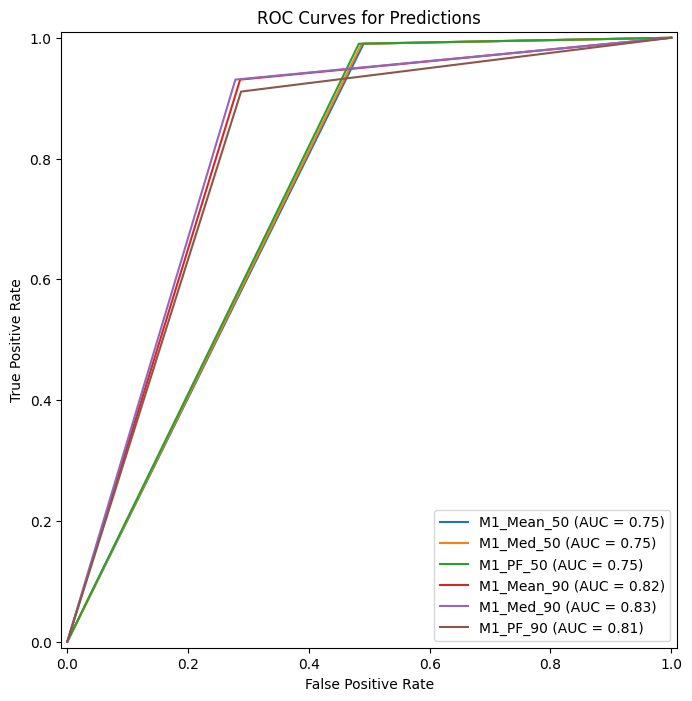

In [34]:
ground_truth_col = 'DF'
roc_results = compute_roc(ROC_df, ground_truth_col, columns_after_df)



# Optional: Plot ROC curves for each column
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
for pred_col in columns_after_df:
    fpr, tpr, _ = roc_curve(ROC_df['DF'], ROC_df[pred_col])
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr), estimator_name=pred_col).plot(ax=plt.gca())

plt.title('ROC Curves for Predictions')
plt.legend(loc='lower right')
plt.show()

In [35]:
print(roc_results)

  Prediction Column   TP   FP   TN  FN  Sensitivity       FPR  Specificity  \
0        M1_Mean_50  100  312  324   1     0.990099  0.490566     0.509434   
1         M1_Med_50  100  310  326   1     0.990099  0.487421     0.512579   
2          M1_PF_50  100  307  329   1     0.990099  0.482704     0.517296   
3        M1_Mean_90   94  182  454   7     0.930693  0.286164     0.713836   
4         M1_Med_90   94  177  459   7     0.930693  0.278302     0.721698   
5          M1_PF_90   92  183  453   9     0.910891  0.287736     0.712264   

   Accuracy       AUC  
0  0.575305  0.749766  
1  0.578019  0.751339  
2  0.582090  0.753697  
3  0.743555  0.822265  
4  0.750339  0.826196  
5  0.739484  0.811578  
